# Load package and define parameters

In [1]:
REPO = '../..'
WORKFLOW_DATA = f'{REPO}/data/workflow'
EXTERNAL_DATA = f'{REPO}/data/external'
RESULT_DATA = f'{REPO}/data/result/cleaned_files'
FIGURE_FOLDER=f'{REPO}/ata/result/cleaned_figures'
Manuscript_RESULT = f'{REPO}/data/result/manuscript_table/'
import sys
sys.path.append(REPO)
from settings import COLOR_PAlETTE
from utils.visual import *
from utils.misc import mergeRsemGeneOutput
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scPipe as sp
import seaborn as sns
import warnings
import commentjson
from scipy.stats import ranksums
import anndata
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats
import decoupler as dc
import gseapy as gp
### Additional Colormap
with open(f'{RESULT_DATA}/ColorMap.json','r') as f:
    colormap = commentjson.load(f)
COLOR_PAlETTE.update(colormap)
plt.style.use(f'{REPO}/paper.mplstyle')
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
External_Cohort = 'Bassez_et_al'
tumor_MP_gmt_path = f'{RESULT_DATA}/MP_Programs.gmt'
tumor_DEG_gmt_path = f"{Manuscript_RESULT}/Tumor_Cellstate.gmt"
tumor_MP_anno_path = f'{RESULT_DATA}/MetaProgram_Annotation.csv'
adata_path = f'{RESULT_DATA}/scRNA_AyseBassez2021NatMed_Raw.h5ad'
scores_path = f'{WORKFLOW_DATA}/{External_Cohort}/ERpos_HR_BRCA_MetaProgram.csv'
# loading reference file
ref_anno = pd.read_csv(tumor_MP_anno_path )
MP_anno_map = ref_anno[['MetaProgram','MPs']].drop_duplicates().set_index('MetaProgram')['MPs'].to_dict()
ref_ITH=pd.read_table(tumor_MP_gmt_path,header=None,index_col=0).drop([1],axis=1).T


# Load Bassez et al single cell data

In [16]:
# get adata
adata = sc.read(adata_path)
adata = adata[adata.obs.Cancer_Subtype_Celltype=='ER+_Cancer_cell',:]
print(f"Detect N={adata.shape[0]:,} tumor cells with high quality GEX profiles;")
print(f"max(% of mitocondrial reads): {adata.obs['Percent_Mt'].max():.0f}")
# get MP sores on all cells 
scores = pd.read_csv(scores_path,index_col=0)
# select the signature scoring method
signature_method ='VISION'
scores = scores[scores.columns[scores.columns.str.endswith(signature_method)]]
scores.columns = scores.columns.map(lambda x:x.split('_')[0])#.map(MP_anno_map)

obs = adata.obs.loc[scores.index,:]
# attach clinical information
scores = scores.merge(obs,left_index=True,right_index=True)
scores.Timepoint.replace({'T1':'Pre','T2':"Pre",'T4':'On'},inplace=True)

Detect N=28,800 tumor cells with high quality GEX profiles;
max(% of mitocondrial reads): 15


## Perform statistic test on pre-treated samples

In [38]:
from utils.statsTest import lmTest

In [39]:
x='Paper_Expansion'
explored_z=None
random_var='Patient'
dt = scores.loc[scores.Timepoint=='Pre',:]
dt.groupby([x,'TxArm'])[random_var].nunique().rename('N_Pts').reset_index()

,Paper_Expansion,TxArm,N_Pts
0,E,ChemoPembro,0
1,E,Pembro,3
2,NE,ChemoPembro,3
3,NE,Pembro,12


In [40]:
dt[x] = pd.Categorical(dt[x],['E','NE'],ordered=True)
dt.Patient = dt.Patient.cat.remove_unused_categories()
result = lmTest(dt=dt,Y=list(MP_anno_map.keys()),x=x,Z=[],explored_z=explored_z,random_var=random_var)
result['Y'] = result['Y'].map(MP_anno_map)
result

,Ctrl,Experiment,Y,log2FC,Pvalue,FDR
0,E,NE,Neurogenesis,-2.016786,0.3792499206969465,0.881052
0,E,NE,Interferon/MHCII(I),-1.213695,0.04708609048165855,0.423775
0,E,NE,ER-II,-0.392977,0.8482088827017888,0.881052
0,E,NE,Stress,-0.170708,0.6062217895602762,0.881052
0,E,NE,EMT-II,0.063106,0.881052411297224,0.881052
0,E,NE,ER-I,0.352356,0.6923488731797718,0.881052
0,E,NE,Cell_Cycle,0.708079,0.4101512408343899,0.881052
0,E,NE,EMT-I,NaN,0.5006455723056873,0.881052
0,E,NE,EMT-III,NaN,0.3067510988170762,0.881052


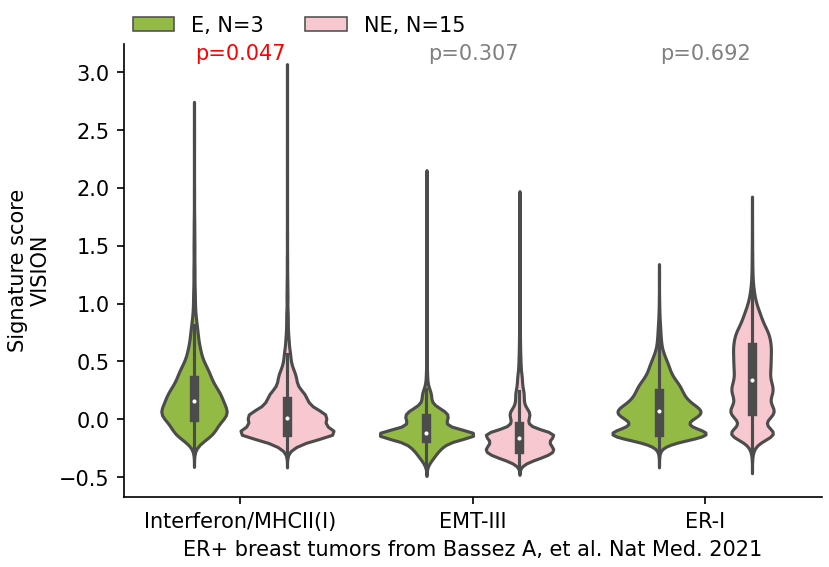

In [42]:
show_mps = ['Interferon/MHCII(I)','EMT-III','ER-I']#,'Neurogenesis']
COLOR_PAlETTE[x]={
    'NE':'pink',
    'E':'yellowgreen'
}
pvalues = result.loc[(result.Y.isin(show_mps)),:].set_index('Y')['Pvalue']
dt.rename(columns=MP_anno_map,inplace=True)
fig,ax=plt.subplots(1,1,dpi=150)
sns.violinplot(data=dt[show_mps+[x]].melt(id_vars=[x]),
                x='variable',y='value',hue=x,showfliers=False,
                palette=COLOR_PAlETTE[x],ax=ax)
y_loc =ax.get_ylim()[1]
for xtick in ax.get_xticklabels():
    x_loc,_ = xtick.get_position()
    text = xtick.get_text()
    if pvalues[text] >= 0.05:
        c='gray'
        label = f"p={pvalues[text]:.3f}"
    else:
        label = f"p={pvalues[text]:.3f}"
        c = 'red'
    ax.text(x_loc,y_loc,s=label,ha='center',va='top',color=c)
n_pt_label = ','.join([ f"N({k})={v}"for k,v in dt.drop_duplicates([random_var])[x].value_counts().to_dict().items()])
ax.set(xlabel='ER+ breast tumors from Bassez A, et al. Nat Med. 2021',ylabel=f'Signature score\n{signature_method}')
legend = ax.legend(loc=(0,1),frameon=False,ncol=2)
for text in legend.texts:
    label = text.get_text()
    new_label = f'{label}, N={dt.drop_duplicates([random_var])[x].value_counts().to_dict()[label]}'
    text.set_text(new_label)

# TCGA

In [3]:
brca = sc.read(f"{EXTERNAL_DATA}/BRCA.h5ad")
# from cbioportal
#https://www.cbioportal.org/study/summary?id=brca_tcga_pub2015%2Cbrca_tcga%2Cbrca_tcga_pan_can_atlas_2018%2Cbrca_tcga_pub
her2_status = pd.read_csv(f'{EXTERNAL_DATA}/IHC-HER2.full.txt',sep='\t')
er_status = pd.read_csv(f'{EXTERNAL_DATA}/ER_Status_By_IHC.full.txt',sep='\t')
purity=pd.read_csv('http://api.gdc.cancer.gov/data/4f277128-f793-4354-a13d-30cc7fe9f6b5',sep='\t').set_index('array')['purity']

brca.obs['HER2-IHC'] = her2_status.set_index('Sample ID')['IHC-HER2']
brca.obs['ER-IHC'] = er_status.set_index('Sample ID')['ER Status By IHC']
brca.obs['Tumor_Purity'] = purity
# brca.obs['Patient'] = brca.obs.index.map(lambda x:'-'.join(x.split('-')[:3]))
del her2_status,er_status,purity
## subset primary hr+ breast cancer
brca = brca[(brca.obs['sample_type.samples']=='Primary Tumor')&
            (brca.obs['HER2-IHC'].isin(['Negative', 'Equivocal']))&
            (brca.obs['ER-IHC']=='Positive')&
            (brca.obs.Is_Tumor_Biopsy&
            (~brca.obs['Tumor_Purity'].isna()))&
            (brca.obs['prior_malignancy.diagnoses']=='no')&
            (brca.obs['history_of_neoadjuvant_treatment']=='No')&
            (brca.obs['distant_metastasis_present_ind2']=='NO')&
            (brca.obs['gender.demographic']=='female'),:] # with purity information

brca.write(f'{EXTERNAL_DATA}/tcga_primary_hr_pos_brca.h5ad')
## format TPM 
tpm=pd.DataFrame(brca.layers['tpm'].toarray(),index=brca.obs_names,columns=brca.var_names).T

In [4]:
mut = sc.read(f'{EXTERNAL_DATA}/TCGA_BRCA/BRCA.h5ad')
brca.obs =brca.obs.merge(sc.get.obs_df(mut,['TP53']),left_index=True,right_index=True,
                         how='left')

## Store CPM

In [5]:
cpm = pd.DataFrame(
    sc.pp.normalize_total(brca,target_sum=1e6,inplace=False)['X'].toarray(),
    index=brca.obs_names,
    columns = brca.var_names
)
cpm.T.to_csv(f'{EXTERNAL_DATA}/TCGA_BRCA/CPM.tsv',sep='\t')

## Cellstate fraction

In [6]:
fraction  =  pd.read_csv(f'{EXTERNAL_DATA}/TCGA_BRCA/Cellstate_Bisque_Fraction_Estimation.csv',
                          index_col=0)

fraction.index=fraction.index.str.replace('.','-')
norm_score = fraction.copy()#[['Tumor.EMT-III','Tumor.ER-I']].copy()
# tumor_frac = fraction.loc[:,fraction.columns.str.startswith('Tumor')].sum(axis=1)
# norm_score = (norm_score.T/ tumor_frac).T
norm_score['TP53'] = brca.obs.loc[norm_score.index,'TP53']
norm_score.dropna(subset=['TP53'],inplace=True)
norm_score['TP53']=norm_score['TP53'].map(lambda x:'Mut' if x > 0 else 'WT')

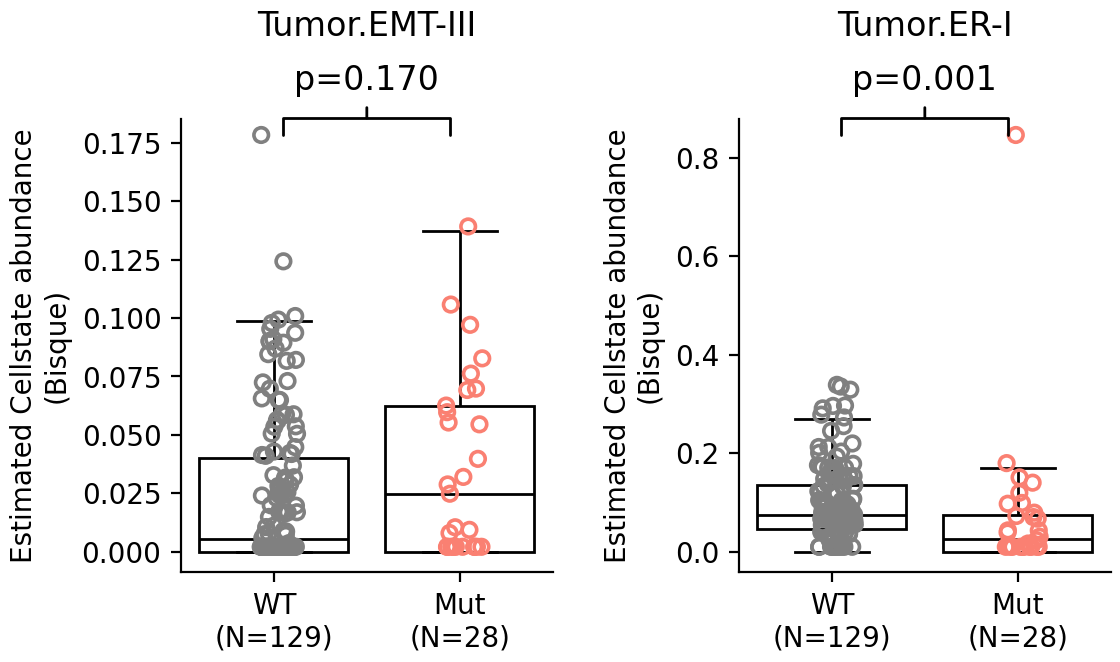

In [7]:
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
order=['WT','Mut']
palette={'WT':'gray','Mut':'salmon'}
ylabel='Estimated Cellstate abundance\n(Bisque)'
x='TP53'
fig,axs = plt.subplots(1,2,figsize=(6,3),dpi=200)

## Plot EMT-III
ax=axs[0]
# y='Tumor.Interferon/MHCII(I)'
y='Tumor.EMT-III'
sns.stripplot(data=norm_score,y=y,x=x,ax=ax,palette=palette,order=order,
              marker="$\circ$", ec="face",size=10)
sns.boxplot(data=norm_score,y=y,x=x,ax=ax,order=order,
            showfliers=False,linewidth=1,**PROPS)
ax.set(xlabel='',ylabel=ylabel)
ax.set_title(y,pad=30)
xticklabels=[]
for handle in ax.get_xticklabels():
    text = handle.get_text()
    xticklabels.append(f"{text}\n(N={(norm_score[x]==text).sum()})")
ax.set_xticklabels(xticklabels)
##### stats
z,pvalue = ranksums(norm_score.loc[norm_score[x]=='Mut',y].values,
                  norm_score.loc[norm_score[x].isin(['WT']),y].values)
ax.annotate(f"p={pvalue:.3f}", xy=(0.5, .99), xytext=(0.5, 1.05), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=.5', lw=1, color='k'))

## Plot ER-I
ax=axs[1]
y='Tumor.ER-I'
sns.stripplot(data=norm_score,y=y,x=x,ax=ax,palette=palette,order=order,
              marker="$\circ$", ec="face",size=10)
sns.boxplot(data=norm_score,y=y,x=x,ax=ax,order=order,
            showfliers=False,linewidth=1,**PROPS)
ax.set(xlabel='',ylabel=ylabel)
ax.set_title(y,pad=30)
xticklabels=[]
for handle in ax.get_xticklabels():
    text = handle.get_text()
    xticklabels.append(f"{text}\n(N={(norm_score[x]==text).sum()})")
ax.set_xticklabels(xticklabels)
##### stats
z,pvalue = ranksums(norm_score.loc[norm_score[x]=='Mut',y].values,
                  norm_score.loc[norm_score[x].isin(['WT']),y].values)
ax.annotate(f"p={pvalue:.3f}", xy=(0.5, .99), xytext=(0.5, 1.05), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=.5', lw=1, color='k'))

plt.subplots_adjust(wspace=.5)

## Calculate MP scores via VISION

In [8]:
n_umi = brca.X.toarray().sum(axis=1)
scaled_counts = (brca.X.toarray().T / n_umi) * np.median(n_umi)
brca.X = scaled_counts.T
# brca.X = brca.layers['tpm']

In [9]:
mp_result = sp.ext.VISION(data=brca,gmt_files=[tumor_DEG_gmt_path],outdir='.')

Rscript /home/analysis/scPipe/scPipe/Rscripts/VISION.R --gmt_files ../../data/result/manuscript_table//Tumor_Cellstate.gmt --h5ad /tmp/tmpz1lpbt11/count.h5ad --output_file /tmp/tmpz1lpbt11/vision.tsv
$gmt_files
[1] "../../data/result/manuscript_table//Tumor_Cellstate.gmt"

$h5ad
[1] "/tmp/tmpz1lpbt11/count.h5ad"

$output_file
[1] "/tmp/tmpz1lpbt11/vision.tsv"



Loading data from ../../data/result/manuscript_table//Tumor_Cellstate.gmt ...

Using 54036/58387 genes detected in 0.10% of cells for signature analysis.
See the `sig_gene_threshold` input to change this behavior.

Evaluating signature scores on cells...

Evaluating signature-gene importance...



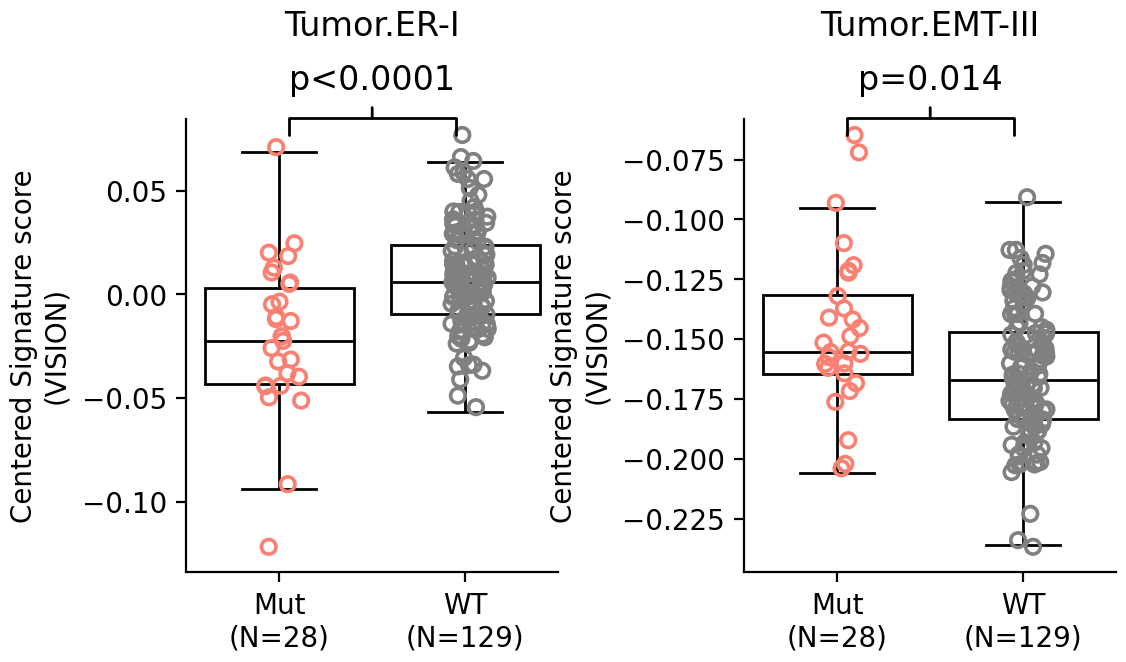

In [10]:
# fraction  =  pd.read_csv(f'{EXTERNAL_DATA}/TCGA_BRCA/Celltype_Bisque_Fraction_Estimation.csv',
#                           index_col=0)
# fraction.index=fraction.index.str.replace('.','-')
# fraction = fraction.loc[fraction.Tumor>0.2,:]
# mp_result = gp.gsva(
#     data=tpm,
#     gene_sets=tumor_DEG_gmt_path,
#     outdir=None,
#     sample_norm_method='rank',
#     permutation_num=0, 
#     no_plot=True,
#     processes=4,
# )
norm_score = mp_result.copy()#.res2d.pivot_table(index='Name',columns='Term',values='ES')#.rename(columns=MP_anno_map).copy()
norm_score = (norm_score.T - norm_score.mean(axis=1)).T 
# norm_score = (norm_score.T / norm_score.std(axis=1)).T 
# norm_score = norm_score.T / cl
# norm_score = (norm_score.loc[fraction.index,:].T / fraction['Tumor']).T
norm_score['TP53'] = brca.obs.loc[norm_score.index,'TP53']
norm_score.dropna(subset=['TP53'],inplace=True)
norm_score['TP53']=norm_score['TP53'].map(lambda x:'Mut' if x > 0 else 'WT')


PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
order=['Mut','WT']
palette={'WT':'gray','Mut':'salmon'}
ylabel='Centered Signature score\n(VISION)'
x='TP53'
fig,axs = plt.subplots(1,2,figsize=(6,3),dpi=200)

## Plot EMT-III
ax=axs[1]
# y='Tumor.Interferon/MHCII(I)'
y='Tumor.EMT-III'
sns.stripplot(data=norm_score,y=y,x=x,ax=ax,palette=palette,order=order,
              marker="$\circ$", ec="face",size=10)
sns.boxplot(data=norm_score,y=y,x=x,ax=ax,order=order,
            showfliers=False,linewidth=1,**PROPS)
ax.set(xlabel='',ylabel=ylabel)
ax.set_title(y,pad=30)
xticklabels=[]
for handle in ax.get_xticklabels():
    text = handle.get_text()
    xticklabels.append(f"{text}\n(N={(norm_score[x]==text).sum()})")
ax.set_xticklabels(xticklabels)
##### stats
z,pvalue = ranksums(norm_score.loc[norm_score[x]=='Mut',y].values,
                  norm_score.loc[norm_score[x].isin(['WT']),y].values)
ax.annotate(f"p={pvalue:.3f}", xy=(0.5, .99), xytext=(0.5, 1.05), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=.5', lw=1, color='k'))

## Plot ER-I
ax=axs[0]
y='Tumor.ER-I'
sns.stripplot(data=norm_score,y=y,x=x,ax=ax,palette=palette,order=order,
              marker="$\circ$", ec="face",size=10)
sns.boxplot(data=norm_score,y=y,x=x,ax=ax,order=order,
            showfliers=False,linewidth=1,**PROPS)
ax.set(xlabel='',ylabel=ylabel)
ax.set_title(y,pad=30)
xticklabels=[]
for handle in ax.get_xticklabels():
    text = handle.get_text()
    xticklabels.append(f"{text}\n(N={(norm_score[x]==text).sum()})")
ax.set_xticklabels(xticklabels)
##### stats
z,pvalue = ranksums(norm_score.loc[norm_score[x]=='Mut',y].values,
                  norm_score.loc[norm_score[x].isin(['WT']),y].values)
ax.annotate(f"p={pvalue:.3f}" if pvalue >0.0001 else 'p<0.0001', xy=(0.5, .99), xytext=(0.5, 1.05), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=.5', lw=1, color='k'))

plt.subplots_adjust(wspace=.5)

## Calculate Hallmark pathway scores through gsva

In [268]:
brca.obs['Patient'] = brca.obs.index.map(lambda x:x[:-3])
clin = brca.obs.drop_duplicates(['Patient']).set_index('Patient')

In [269]:
norm_score.index = norm_score.index.map(lambda x:x[:-3])
norm_score = norm_score.groupby(level=0).mean()

In [282]:
duration = 'PFI.time'
event = 'PFI'
variables = [duration,event,'age_at_initial_pathologic_diagnosis','tumor_stage.diagnoses']
confounders = ['age_at_initial_pathologic_diagnosis','tumor_stage.diagnoses']
for v in variables:
    norm_score[v] = clin[v]

In [283]:
from utils.prognostic_test import prognostic_test
import forestplot as fp

In [284]:
uni_test_result = []
for test_var in ['Tumor.ER-I','Tumor.EMT-III']:
    uni_test_result.append(prognostic_test(df=norm_score.dropna(),test_var=test_var,duration_col=duration,event_col=event,confounders=confounders))
uni_test_result = pd.concat(uni_test_result,ignore_index=True)
uni_test_result.loc[uni_test_result['group']=='age_at_initial_pathologic_diagnosis','label'] = "In years"
uni_test_result

,coef,exp(coef),se(coef),coef lower 90%,coef upper 90%,exp(coef) lower 90%,exp(coef) upper 90%,cmp to,z,p,-log2(p),label,group,N,est_and_ci
0,7.983105,2931.018985,11.262344,-10.541802,26.508012,2.640911e-05,3.252996e+11,0.0,0.708832,0.478429,1.063623,continuous,Tumor.ER-I,157,"2931.02[0.00,325299611858.51]"
1,-4.945955,0.007112,11.195633,-23.361132,13.469223,7.151368e-11,7.073087e+05,0.0,-0.441775,0.658652,0.602412,continuous,Tumor.EMT-III,157,"0.01[0.00,707308.73]"


In [265]:
# uni_test_result['N'] = uni_test_result['N'].astype(str)
# # uni_test_result['group'] = uni_test_result['group'].replace(NAME_Map)
# ax = fp.forestplot(uni_test_result.sort_values('p'),  # the dataframe with results data
#               estimate="exp(coef)",  # col containing estimated effect size 
#               ll="exp(coef) lower 90%", hl="exp(coef) upper 90%",  # columns containing conf. int. lower and higher limits
#               varlabel="label",  # column containing variable label
#               groupvar="group",  # Add variable groupings 
#               pval="p",  # Column of p-value to be reported on right
#               color_alt_rows=True,  # Gray alternate rows
#               decimal_precision=4,
#               annote=['N','est_and_ci'],
#               annoteheaders=["N(pt)",'Est. (90% Conf. Int.)'],  # ^corresponding headers,
#               xlabel="Hazard Ratio",
#               table=True,  # Format as a table
#               xline=1,
#               figsize=(7,12),
#               # Additional kwargs for customizations
#               **{
#                  "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
#                  "xlinecolor": "#808080",  # gray color for x-reference line
#                  "xtick_size": 15,  # adjust x-ticker fontsize,
#                  "thresholds":(0.001, 0.01, 0.05) # p value threshold
#                 }  
#               )

# Bulk Data From the Same Cohort

In [3]:
obs_path = f'{REPO}/data/result/manuscript_table/GEX_OBS.csv'
obs = pd.read_csv(obs_path,index_col=0)
obs = obs.loc[~obs.Cellstate.isin(['Immune','Stromal']),:] # remove uncharacterized cellstate
ground_truth = pd.crosstab(obs['Sample_Short'],obs['Cellstate'],normalize=0)

In [4]:
obs.Celltype.unique()

array(['Plasma', 'Myeloid', 'B', 'Tumor', 'Epithelial', 'Endothelial',
       'Adipocytes', 'CAF', 'SMC', 'Pericyte', 'CD8T', 'CD4T'],
      dtype=object)

In [107]:
## ------------------- Prepare for the CPM Table

# clinMap = pd.read_csv(f"{EXTERNAL_DATA}/clin_IHC.csv",index_col=0).dropna(subset=['CCG Piece ID'])
# clinMap = clinMap['CCG Piece ID'].map(lambda x:'P'+'.'.join(x.split('_')[1:3])).to_dict()
# counts = pd.read_csv(f'{EXTERNAL_DATA}/HRPos_16_466/bulkRNA_Count.csv',index_col=0)
# counts.columns = counts.columns.map(clinMap)
# # remove samples that do not have single cell profiles
# counts = counts.loc[:,counts.columns.isin(groud_truth.index)] 
# cpm = pd.DataFrame(
#     sc.pp.normalize_total(anndata.AnnData(X=counts.T),target_sum=1e6,inplace=False)['X'],
#     index=counts.columns,
#     columns =counts.index)
# cpm.T.to_csv(f'{EXTERNAL_DATA}/HRPos_16_466/CPM.tsv',sep='\t')

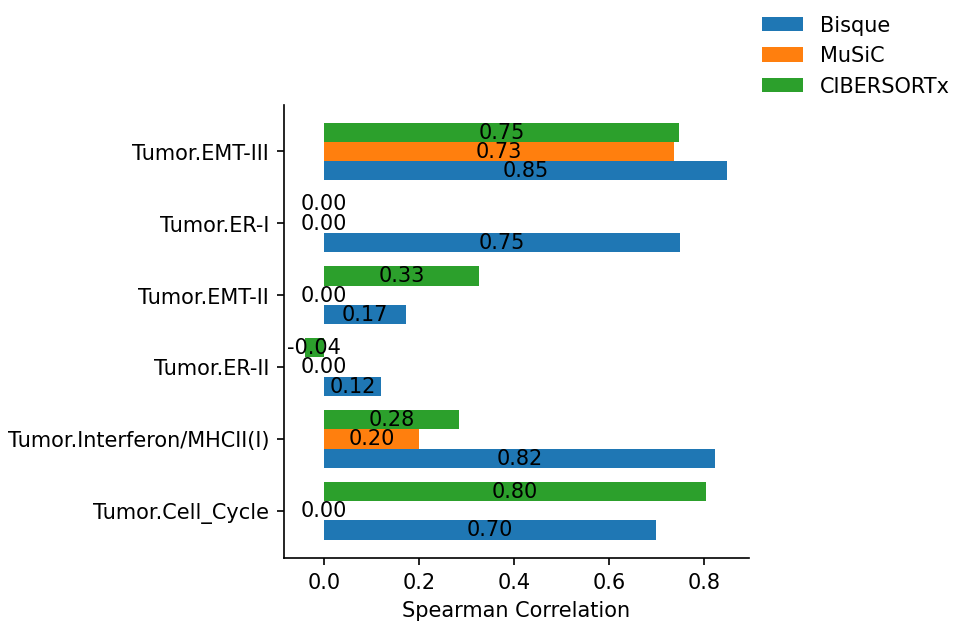

In [99]:
cor_table = []
for deconv_method in ['Bisque','MuSiC','CIBERSORTx']:
    fraction  =  pd.read_csv(f'{EXTERNAL_DATA}/HRPos_16_466/Cellstate_{deconv_method}_Fraction_Estimation.csv',index_col=0)
    fraction = fraction[ground_truth.columns.tolist()]
    cor_df = ground_truth.loc[fraction.index,:].apply(lambda v: fraction.corrwith(v,method='pearson'),axis=0)
    cellstate_cor = pd.Series(np.diag(cor_df.loc[cor_df.index,cor_df.index]),
                              index=cor_df.index,
                              name=deconv_method)
    
    cor_table.append(cellstate_cor)
cor_table = pd.concat(cor_table,axis=1)

fig,ax=plt.subplots(1,1,figsize=(4,4),dpi=150)
(cor_table.loc[['Tumor.Cell_Cycle','Tumor.Interferon/MHCII(I)',
                'Tumor.ER-II','Tumor.EMT-II','Tumor.ER-I','Tumor.EMT-III'],:].
 # .sort_values(by=['MuSiC','Bisque']).
 plot(kind='barh',ax=ax,width=.8)
)
ax.set(xlabel='Spearman Correlation')
for containers in ax.containers:
    ax.bar_label(containers,fmt='%.2f',label_type='center')
ax.legend(loc=(1.01,1))

# Keenan et al 2021

In [11]:
# terra = pd.read_csv(f'{EXTERNAL_DATA}/Keenan_2021_SourceData/sample.tsv',sep='\t')
# for _,row in terra.iterrows():
#     url = row['rsem_gene']
#     sample_name = row['participant']
#     store_path = f"{EXTERNAL_DATA}/Keenan_2021_SourceData/rsem/{sample_name}.genes.results.gz"
#     !gsutil cp $url $store_path

## Load data

In [12]:
clin = pd.read_excel(f'{EXTERNAL_DATA}/Keenan_2021_SourceData/41467_2021_25769_MOESM5_ESM.xlsx',
                   skiprows=1,sheet_name='Fig 1, 2, 6a-c, Suppl Fig 3, 4',index_col=0)
clin.index=clin.index.map(lambda x:f"P{x}")

In [13]:
qced_pts =  pd.read_excel(f'{EXTERNAL_DATA}/Keenan_2021_SourceData/41467_2021_25769_MOESM5_ESM.xlsx',
                   skiprows=1,sheet_name='Suppl Fig 7, 8d-e, 9e-f',index_col=0).columns.str.replace('Patient','P').tolist()
counts,tpm= mergeRsemGeneOutput(f'{EXTERNAL_DATA}/Keenan_2021_SourceData/rsem')
counts.index = counts.index.map(lambda x: '_'.join(x.split('_')[1:])).str.replace('^[0-9]_','')
counts = counts.groupby(level=0).mean().round(0)

tpm.index = tpm.index.map(lambda x: '_'.join(x.split('_')[1:])).str.replace('^[0-9]_','')
tpm = tpm.groupby(level=0).mean()

counts.columns = counts.columns.map(lambda x: 'P'+str(int(x.split('_')[-1])))
tpm.columns = tpm.columns.map(lambda x: 'P'+str(int(x.split('_')[-1])))
tpm = tpm[qced_pts]
counts = counts[qced_pts]
tpm.T.to_csv(f'{EXTERNAL_DATA}/Keenan_2021_SourceData/TPM.tsv',sep='\t')

## Store CPM

In [14]:
# cpm = pd.DataFrame(
#     sc.pp.normalize_total(keenan,target_sum=1e6,inplace=False)['X'],
#     index=keenan.obs_names,
#     columns = keenan.var_names)
# cpm.T.to_csv(f'{EXTERNAL_DATA}/Keenan_2021_SourceData/CPM.tsv',sep='\t')

## single sample GSVA on signatures

In [15]:
gsva_res = gp.gsva(
    data=tpm,
    gene_sets=tumor_DEG_gmt_path,
    outdir=None,
    sample_norm_method='rank',
    permutation_num=0, 
    no_plot=True,
    processes=4,
)

In [16]:
norm_score  = gsva_res.res2d.pivot_table(index='Name',columns='Term',values='ES')
norm_score = (norm_score.T - norm_score.mean(axis=1)).T
norm_score['TP53'] = clin.loc[norm_score.index,'TP53'].map(lambda x:'Mut' if x > 0 else 'WT')
norm_score['Clinical Benefit'] = clin.loc[norm_score.index,'Clinical Benefit']
norm_score['Response'] = clin.loc[norm_score.index,'Response']
norm_score['Therapy'] = clin.loc[norm_score.index,'Therapy']
norm_score['Biopsy'] = clin.loc[norm_score.index,'Biopsy']
norm_score = norm_score.loc[(norm_score.Therapy=='Erib Pembro') &(norm_score.Biopsy!='Metastatic'),:]

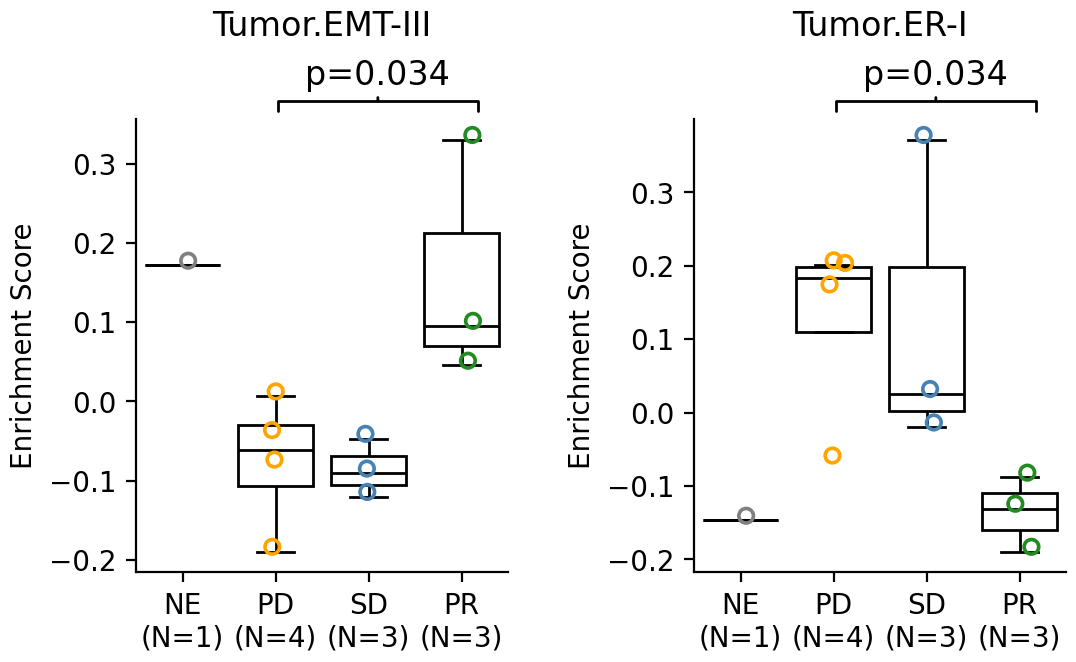

In [17]:
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
order=['NE','PD','SD','PR']
palette={'NE':'gray','PD':'orange','SD':'steelblue','PR':'forestgreen'}
ylabel='Enrichment Score'
x='Response'
fig,axs = plt.subplots(1,2,figsize=(6,3),dpi=200)

## Plot EMT-III
ax=axs[0]
# y='Tumor.Interferon/MHCII(I)'
y='Tumor.EMT-III'
sns.stripplot(data=norm_score,y=y,x=x,ax=ax,palette=palette,order=order,
              marker="$\circ$", ec="face",size=10)
sns.boxplot(data=norm_score,y=y,x=x,ax=ax,order=order,
            showfliers=False,linewidth=1,**PROPS)
ax.set(xlabel='',ylabel=ylabel)
ax.set_title(y,pad=30)
xticklabels=[]
for handle in ax.get_xticklabels():
    text = handle.get_text()
    xticklabels.append(f"{text}\n(N={(norm_score[x]==text).sum()})")
ax.set_xticklabels(xticklabels)
##### stats
z,pvalue = ranksums(norm_score.loc[norm_score[x]=='PR',y].values,
                  norm_score.loc[norm_score[x].isin(['PD']),y].values)
ax.annotate(f"p={pvalue:.3f}", xy=(0.65, 1.04), xytext=(0.65, 1.06), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=3, lengthB=.3', lw=1, color='k'))
# ax.annotate('', xy=(0.5, .93), xytext=(0.5, 0.9301), xycoords='axes fraction', 
#             fontsize=12, ha='center', va='bottom',
#             arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=.2', lw=1, color='k'))

## Plot ER-I
ax=axs[1]
y='Tumor.ER-I'
sns.stripplot(data=norm_score,y=y,x=x,ax=ax,palette=palette,order=order,
              marker="$\circ$", ec="face",size=10)
sns.boxplot(data=norm_score,y=y,x=x,ax=ax,order=order,
            showfliers=False,linewidth=1,**PROPS)
ax.set(xlabel='',ylabel=ylabel)
ax.set_title(y,pad=30)
xticklabels=[]
for handle in ax.get_xticklabels():
    text = handle.get_text()
    xticklabels.append(f"{text}\n(N={(norm_score[x]==text).sum()})")
ax.set_xticklabels(xticklabels)
##### stats
z,pvalue = ranksums(norm_score.loc[norm_score[x]=='PD',y].values,
                  norm_score.loc[norm_score[x].isin(['PR']),y].values)
ax.annotate(f"p={pvalue:.3f}", xy=(0.65, 1.04), xytext=(0.65, 1.06), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=3, lengthB=.3', lw=1, color='k'))
# ax.annotate('', xy=(0.5, 1), xytext=(0.5, 1.001), xycoords='axes fraction', 
#             fontsize=12, ha='center', va='bottom',
#             arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=.2', lw=1, color='k'))

plt.subplots_adjust(wspace=.5)

## Cellstate fraction

In [18]:
fraction  =  pd.read_csv(f'{EXTERNAL_DATA}/Keenan_2021_SourceData/Cellstate_Bisque_Fraction_Estimation.csv',
                          index_col=0)
norm_score = fraction.copy()#[['Tumor.EMT-III','Tumor.ER-I']].copy()
tumor_frac = fraction.loc[:,fraction.columns.str.startswith('Tumor')].sum(axis=1)
norm_score = (norm_score.T/ tumor_frac).T
norm_score['Clinical Benefit'] = clin.loc[norm_score.index,'Clinical Benefit']
norm_score['Response'] = clin.loc[norm_score.index,'Response']
norm_score['TP53'] = clin.loc[norm_score.index,'TP53'].map(lambda x:'Mut' if x > 0 else 'WT')

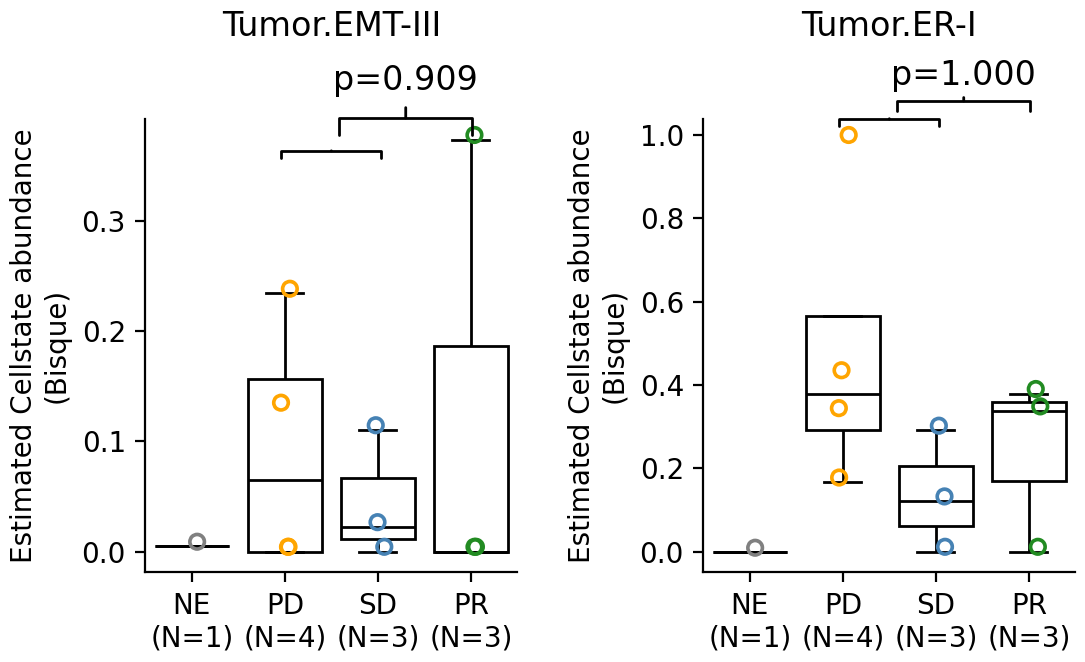

In [19]:
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
order=['NE','PD','SD','PR']
palette={'NE':'gray','PD':'orange','SD':'steelblue','PR':'forestgreen'}
ylabel='Estimated Cellstate abundance\n(Bisque)'
x='Response'
fig,axs = plt.subplots(1,2,figsize=(6,3),dpi=200)

## Plot EMT-III
ax=axs[0]
# y='Tumor.Interferon/MHCII(I)'
y='Tumor.EMT-III'
sns.stripplot(data=norm_score,y=y,x=x,ax=ax,palette=palette,order=order,
              marker="$\circ$", ec="face",size=10)
sns.boxplot(data=norm_score,y=y,x=x,ax=ax,order=order,
            showfliers=False,linewidth=1,**PROPS)
ax.set(xlabel='',ylabel=ylabel)
ax.set_title(y,pad=30)
xticklabels=[]
for handle in ax.get_xticklabels():
    text = handle.get_text()
    xticklabels.append(f"{text}\n(N={(norm_score[x]==text).sum()})")
ax.set_xticklabels(xticklabels)
##### stats
z,pvalue = ranksums(norm_score.loc[norm_score[x]=='PR',y].values,
                  norm_score.loc[norm_score[x].isin(['SD','PD']),y].values)
ax.annotate(f"p={pvalue:.3f}", xy=(0.7, .99), xytext=(0.7, 1.05), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=.5', lw=1, color='k'))
ax.annotate('', xy=(0.5, .93), xytext=(0.5, 0.9301), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=.2', lw=1, color='k'))

## Plot ER-I
ax=axs[1]
y='Tumor.ER-I'
sns.stripplot(data=norm_score,y=y,x=x,ax=ax,palette=palette,order=order,
              marker="$\circ$", ec="face",size=10)
sns.boxplot(data=norm_score,y=y,x=x,ax=ax,order=order,
            showfliers=False,linewidth=1,**PROPS)
ax.set(xlabel='',ylabel=ylabel)
ax.set_title(y,pad=30)
xticklabels=[]
for handle in ax.get_xticklabels():
    text = handle.get_text()
    xticklabels.append(f"{text}\n(N={(norm_score[x]==text).sum()})")
ax.set_xticklabels(xticklabels)
##### stats
z,pvalue = ranksums(norm_score.loc[norm_score[x]=='PR',y].values,
                  norm_score.loc[norm_score[x].isin(['SD','PD']),y].values)
ax.annotate(f"p={pvalue:.3f}", xy=(0.7, 1.04), xytext=(0.7, 1.06), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=.3', lw=1, color='k'))
ax.annotate('', xy=(0.5, 1), xytext=(0.5, 1.001), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=.2', lw=1, color='k'))

plt.subplots_adjust(wspace=.5)

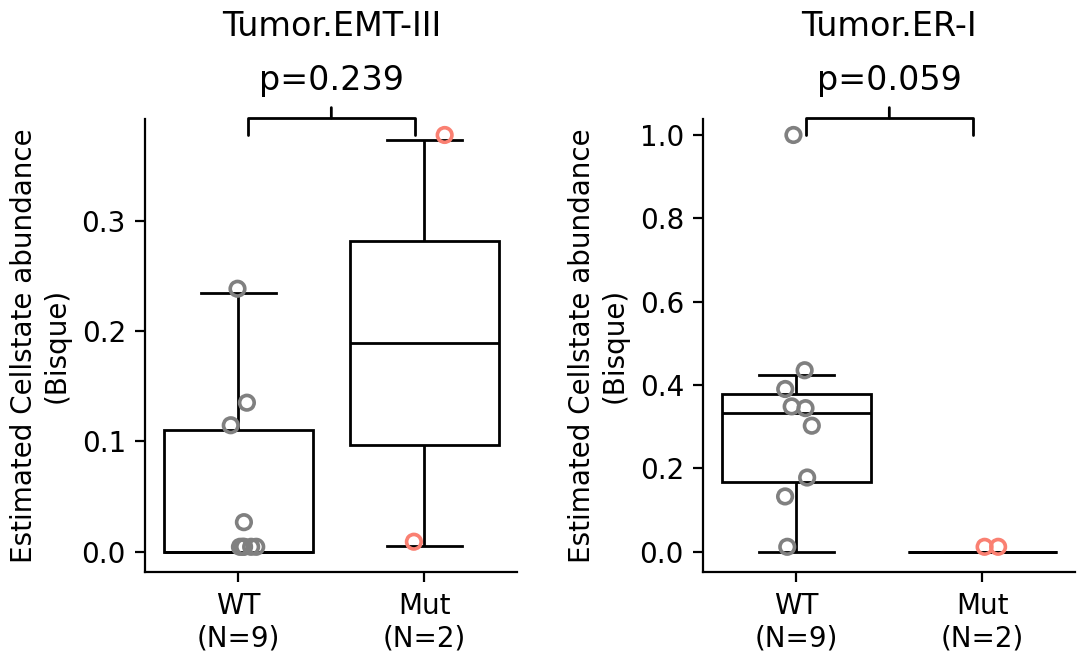

In [20]:
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
order=['WT','Mut']
palette={'WT':'gray','Mut':'salmon'}
ylabel='Estimated Cellstate abundance\n(Bisque)'
x='TP53'
fig,axs = plt.subplots(1,2,figsize=(6,3),dpi=200)

## Plot EMT-III
ax=axs[0]
# y='Tumor.Interferon/MHCII(I)'
y='Tumor.EMT-III'
sns.stripplot(data=norm_score,y=y,x=x,ax=ax,palette=palette,order=order,
              marker="$\circ$", ec="face",size=10)
sns.boxplot(data=norm_score,y=y,x=x,ax=ax,order=order,
            showfliers=False,linewidth=1,**PROPS)
ax.set(xlabel='',ylabel=ylabel)
ax.set_title(y,pad=30)
xticklabels=[]
for handle in ax.get_xticklabels():
    text = handle.get_text()
    xticklabels.append(f"{text}\n(N={(norm_score[x]==text).sum()})")
ax.set_xticklabels(xticklabels)
##### stats
z,pvalue = ranksums(norm_score.loc[norm_score[x]=='Mut',y].values,
                  norm_score.loc[norm_score[x].isin(['WT']),y].values)
ax.annotate(f"p={pvalue:.3f}", xy=(0.5, .99), xytext=(0.5, 1.05), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=.5', lw=1, color='k'))

## Plot ER-I
ax=axs[1]
y='Tumor.ER-I'
sns.stripplot(data=norm_score,y=y,x=x,ax=ax,palette=palette,order=order,
              marker="$\circ$", ec="face",size=10)
sns.boxplot(data=norm_score,y=y,x=x,ax=ax,order=order,
            showfliers=False,linewidth=1,**PROPS)
ax.set(xlabel='',ylabel=ylabel)
ax.set_title(y,pad=30)
xticklabels=[]
for handle in ax.get_xticklabels():
    text = handle.get_text()
    xticklabels.append(f"{text}\n(N={(norm_score[x]==text).sum()})")
ax.set_xticklabels(xticklabels)
##### stats
z,pvalue = ranksums(norm_score.loc[norm_score[x]=='Mut',y].values,
                  norm_score.loc[norm_score[x].isin(['WT']),y].values)
ax.annotate(f"p={pvalue:.3f}", xy=(0.5, .99), xytext=(0.5, 1.05), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=.5', lw=1, color='k'))

plt.subplots_adjust(wspace=.5)

## Perform DEGs between TP53 mutation status

In [7]:
keenan = anndata.AnnData(X=counts.T,obs=clin.loc[counts.columns,:])
keenan = keenan[(keenan.obs.Therapy=='Erib Pembro') &(keenan.obs.Biopsy!='Metastatic'),:]
keenan.obs['Clinical Benefit'] = keenan.obs['Clinical Benefit'].map({1:"CB",0:"NCB"})
keenan.obs['TP53'] = keenan.obs['TP53'].map(lambda x:'Mut' if x > 0 else 'WT')

In [8]:
# Obtain genes that pass the thresholds
group = 'TP53'
genes = dc.filter_by_expr(keenan, group=group, min_count=10, min_total_count=15)
# Filter by these genes
keenan_filtered = keenan[:, genes].copy()

# Build DESeq2 object
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=keenan_filtered,
    design_factors=[group],
    continuous_factors=['Purity'],
    refit_cooks=True,
    inference=inference,
)
# Compute LFCs
dds.deseq2()

# Running Wald test
stat_res = DeseqStats(
    dds,
    contrast=[group, 'Mut', 'WT'],
    inference=inference,
)
stat_res.summary()
results =  stat_res.results_df

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 3.12 seconds.

Fitting dispersion trend curve...
... done in 1.47 seconds.

Fitting MAP dispersions...
... done in 4.69 seconds.

Fitting LFCs...
... done in 2.66 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: TP53 Mut vs WT
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene_id                                                                       
A1BG        212.049968        1.579566  0.737412  2.142041  0.032190  0.226489
A1BG-AS1    195.848443       -1.346763  0.494341 -2.724359  0.006443  0.091664
A2M       17489.286971        0.168117  0.349437  0.481108  0.630440  0.860572
A2M-AS1     112.116728       -1.209120  0.671683 -1.800136  0.071839  0.341009
A2ML1       213.686948        3.582073  1.365522  2.623226  0.008710  0.109903
...                ...             ...       ...       ...       ...       ...
ZXDC       1108.699215        0.045819  0.304525  0.150460  0.880401  0.964844
ZYG11A      237.904082        0.298462  0.621485  0.480241  0.631056  0.860854
ZYG11B     1531.481454       -0.426803  0.422703 -1.009700  0.312639  0.658164
ZYX        4685.427039        0.082639  0.331108  0.249583  0.802910  0.935131

... done in 1.78 seconds.



## GESA on DEGs between TP53 mut vs WT

2024-04-10 16:03:50,456 [WARNING] Duplicated values found in preranked stats: 0.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-10 16:03:50,457 [INFO] Parsing data files for GSEA.............................
2024-04-10 16:03:50,461 [INFO] 0000 gene_sets have been filtered out when max_size=50 and min_size=1
2024-04-10 16:03:50,462 [INFO] 0009 gene_sets used for further statistical testing.....
2024-04-10 16:03:50,462 [INFO] Start to run GSEA...Might take a while..................
2024-04-10 16:03:50,523 [INFO] Congratulations. GSEApy runs successfully................



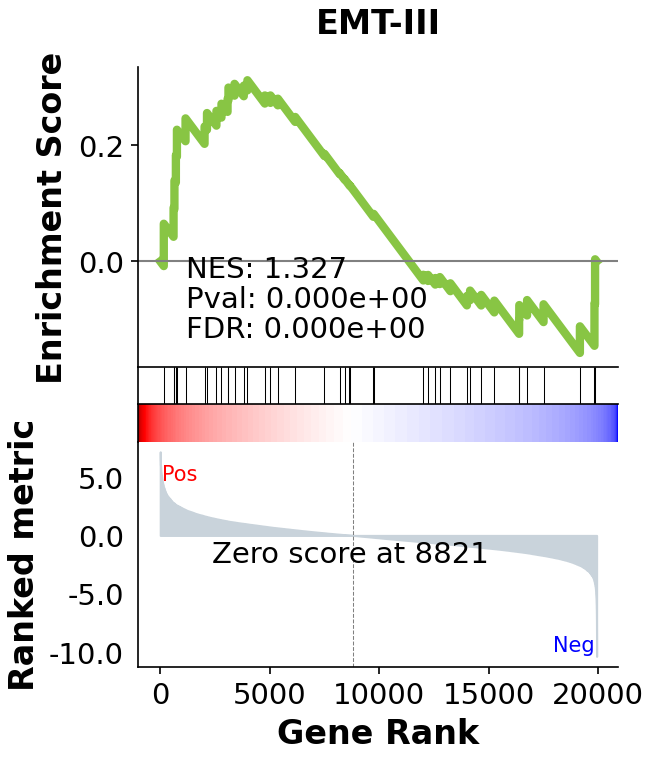

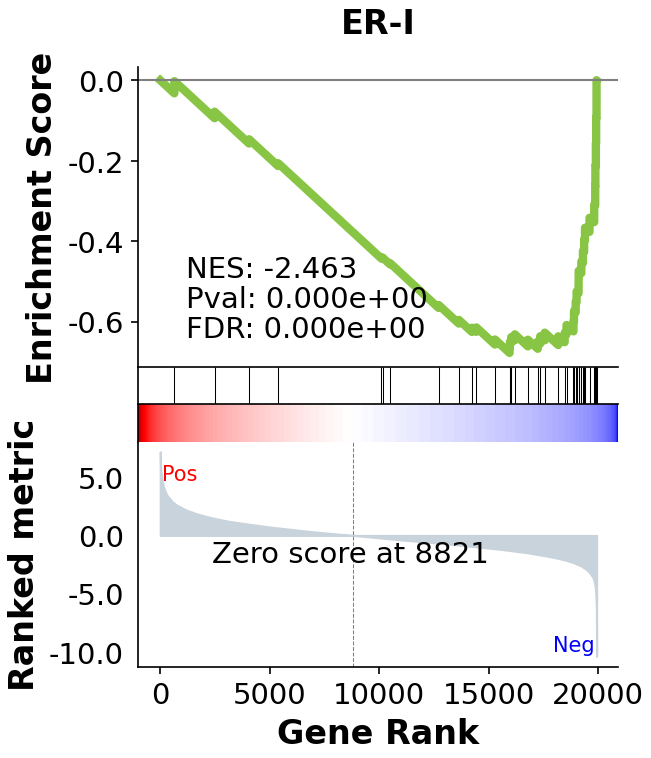

In [9]:
mp_sets = pd.read_csv(tumor_MP_gmt_path,sep='\t',header=None,index_col=0
                     ).T.rename(columns=MP_anno_map).drop([1],axis=0).to_dict('list')
pre_res = gp.prerank(rnk=results['stat'],
                     gene_sets=mp_sets,
                     min_size=1,
                     max_size=50,
                     permutation_num=10, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )
term = 'EMT-III'
fig = pre_res.plot(terms=term)
# fig.suptitle('TP53 Mut vs WT\n(Keenan, Tanya E et al., Nat Commun 2021)',y=1.1)
fig.set_dpi(150)

term = 'ER-I'
fig2 = pre_res.plot(terms=term)
# fig.suptitle('TP53 Mut vs WT\n(Keenan, Tanya E et al., Nat Commun 2021)',y=1.1)
fig2.set_dpi(150)

## VISION scoring on Combination

In [21]:
clin.Therapy.value_counts()

Erib Pembro    27
Eribulin       25
Name: Therapy, dtype: int64

In [22]:
keenan = anndata.AnnData(X=counts.T,obs=clin.loc[counts.columns,:])
keenan = keenan[(keenan.obs.Therapy!='Eribulin') &(keenan.obs.Biopsy!='Metastatic'),:]
keenan.obs['Clinical Benefit'] = keenan.obs['Clinical Benefit'].map({1:"CB",0:"NCB"})
keenan.obs['TP53'] = keenan.obs['TP53'].map(lambda x:'Mut' if x > 0 else 'WT')

In [23]:
n_umi = keenan.X.sum(axis=1)
scaled_counts = (keenan.X.T / n_umi) * np.median(n_umi)
keenan.X = scaled_counts.T
mp_result = sp.ext.VISION(data=keenan,gmt_files=[tumor_DEG_gmt_path],outdir='.')

Rscript /home/analysis/scPipe/scPipe/Rscripts/VISION.R --gmt_files ../../data/result/manuscript_table//Tumor_Cellstate.gmt --h5ad /tmp/tmppako9mse/count.h5ad --output_file /tmp/tmppako9mse/vision.tsv
$gmt_files
[1] "../../data/result/manuscript_table//Tumor_Cellstate.gmt"

$h5ad
[1] "/tmp/tmppako9mse/count.h5ad"

$output_file
[1] "/tmp/tmppako9mse/vision.tsv"



Loading data from ../../data/result/manuscript_table//Tumor_Cellstate.gmt ...

Using 28812/57829 genes detected in 0.10% of cells for signature analysis.
See the `sig_gene_threshold` input to change this behavior.

Evaluating signature scores on cells...

'as(<matrix>, "dgeMatrix")' is deprecated.
Use 'as(as(as(., "dMatrix"), "generalMatrix"), "unpackedMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").
Evaluating signature-gene importance...



In [27]:
norm_score = mp_result.rename(columns=MP_anno_map)
# tumor_ref = norm_score['Tumor']
# norm_score = (norm_score.drop("Tumor",axis=1).T /tumor_ref).T
# norm_score['Tumor']= tumor_ref
# norm_score['Purity']= clin.loc[norm_score.index,'Purity']
# norm_score = (norm_score.T / keenan.obs['Tumor_Fraction']).T
norm_score = (norm_score.T - norm_score.mean(axis=1)).T 
# norm_score_std = norm_score.std(axis=1)
# norm_score = (norm_score.T / norm_score_std).T

In [28]:
norm_score['Clinical Benefit'] = keenan.obs['Clinical Benefit']
norm_score['Response'] = keenan.obs['Response']

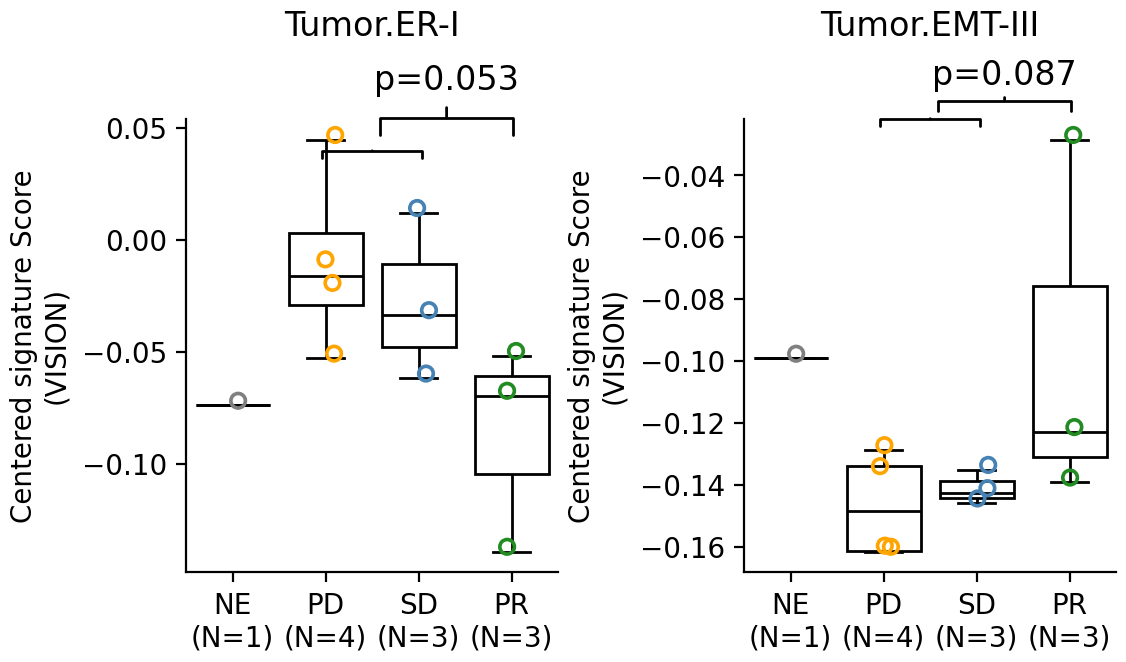

In [29]:
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
order=['NE','PD','SD','PR']
palette={'NE':'gray','PD':'orange','SD':'steelblue','PR':'forestgreen'}
ylabel='Centered signature Score\n(VISION)'
x='Response'
fig,axs = plt.subplots(1,2,figsize=(6,3),dpi=200)

## Plot EMT-III
ax=axs[0]
# y='Interferon/MHCII(I)'
y='Tumor.ER-I'
sns.stripplot(data=norm_score,y=y,x=x,ax=ax,palette=palette,order=order,
              marker="$\circ$", ec="face",size=10)
sns.boxplot(data=norm_score,y=y,x=x,ax=ax,order=order,
            showfliers=False,linewidth=1,**PROPS)
ax.set(xlabel='',ylabel=ylabel)
ax.set_title(y,pad=30)
xticklabels=[]
for handle in ax.get_xticklabels():
    text = handle.get_text()
    xticklabels.append(f"{text}\n(N={(norm_score[x]==text).sum()})")
ax.set_xticklabels(xticklabels)
##### stats
z,pvalue = ranksums(norm_score.loc[norm_score[x]=='PR',y].values,
                  norm_score.loc[norm_score[x].isin(['PD','SD']),y].values)
ax.annotate(f"p={pvalue:.3f}", xy=(0.7, .99), xytext=(0.7, 1.05), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=.5', lw=1, color='k'))
ax.annotate('', xy=(0.5, .93), xytext=(0.5, 0.9301), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=.2', lw=1, color='k'))

## Plot ER-I
ax=axs[1]
y='Tumor.EMT-III'
sns.stripplot(data=norm_score,y=y,x=x,ax=ax,palette=palette,order=order,
              marker="$\circ$", ec="face",size=10)
sns.boxplot(data=norm_score,y=y,x=x,ax=ax,order=order,
            showfliers=False,linewidth=1,**PROPS)
ax.set(xlabel='',ylabel=ylabel)
ax.set_title(y,pad=30)
xticklabels=[]
for handle in ax.get_xticklabels():
    text = handle.get_text()
    xticklabels.append(f"{text}\n(N={(norm_score[x]==text).sum()})")
ax.set_xticklabels(xticklabels)
##### stats
z,pvalue = ranksums(norm_score.loc[norm_score[x]=='PR',y].values,
                  norm_score.loc[norm_score[x].isin(['PD','SD']),y].values)
ax.annotate(f"p={pvalue:.3f}", xy=(0.7, 1.04), xytext=(0.7, 1.06), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2, lengthB=.3', lw=1, color='k'))
ax.annotate('', xy=(0.5, 1), xytext=(0.5, 1.001), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=.2', lw=1, color='k'))

plt.subplots_adjust(wspace=.5)


# ### Positive Contrl
# fig,axs = plt.subplots(1,2,figsize=(6,3),dpi=200)
# ## Plot EMT-III
# ax=axs[0]
# y='Tumor'
# sns.stripplot(data=norm_score,y=y,x=x,ax=ax,palette=palette,order=order,
#               marker="$\circ$", ec="face",size=10)
# sns.boxplot(data=norm_score,y=y,x=x,ax=ax,order=order,
#             showfliers=False,linewidth=1,**PROPS)
# ax.set(xlabel='',ylabel=ylabel,title=y)
# xticklabels=[]
# for handle in ax.get_xticklabels():
#     text = handle.get_text()
#     xticklabels.append(f"{text}\n(N={(norm_score[x]==text).sum()})")
# ax.set_xticklabels(xticklabels)

# ## Plot ER-I
# ax=axs[1]
# y='Purity'
# sns.stripplot(data=norm_score,y=y,x=x,ax=ax,palette=palette,order=order,
#               marker="$\circ$", ec="face",size=10)
# sns.boxplot(data=norm_score,y=y,x=x,ax=ax,order=order,
#             showfliers=False,linewidth=1,**PROPS)
# ax.set(xlabel='',ylabel=ylabel,title=y)
# xticklabels=[]
# for handle in ax.get_xticklabels():
#     text = handle.get_text()
#     xticklabels.append(f"{text}\n(N={(norm_score[x]==text).sum()})")
# ax.set_xticklabels(xticklabels)
    
# plt.subplots_adjust(wspace=.5)

In [88]:
from utils.prognostic_test import prognostic_test
import forestplot as fp

duration = 'PFS Months'
event = 'Progression'
variables = [duration,event,'Purity']
confounders = []
for v in variables+confounders:
    norm_score[v] = clin.loc[norm_score.index,v]
uni_test_result = []
for test_var in ['ER-I','EMT-III','Purity','Interferon/MHCII(I)','Cell_Cycle']:
    uni_test_result.append(prognostic_test(df=norm_score.dropna(),test_var=test_var,duration_col=duration,event_col=event,confounders=confounders))
uni_test_result = pd.concat(uni_test_result,ignore_index=True)
uni_test_result

,coef,exp(coef),se(coef),coef lower 90%,coef upper 90%,exp(coef) lower 90%,exp(coef) upper 90%,cmp to,z,p,-log2(p),label,group,N,Median PFS,est_and_ci
0,0.342158,1.407982,1.096391,-1.461246,2.145561,0.231947,8.546836,0.0,0.312076,0.754983,0.405485,continuous,ER-I,11,,"1.41[0.23,8.55]"
1,-0.115585,0.890845,0.895539,-1.588616,1.357447,0.204208,3.886258,0.0,-0.129067,0.897305,0.156330,continuous,EMT-III,11,,"0.89[0.20,3.89]"
2,4.005695,54.909981,2.041838,0.647170,7.364220,1.910127,1578.484491,0.0,1.961808,0.049785,4.328150,continuous,Purity,11,,"54.91[1.91,1578.48]"
3,-1.193850,0.303052,0.929440,-2.722642,0.334942,0.065701,1.397859,0.0,-1.284484,0.198973,2.329357,continuous,Interferon/MHCII(I),11,,"0.30[0.07,1.40]"
4,0.837904,2.311518,1.503731,-1.635513,3.311322,0.194852,27.421348,0.0,0.557217,0.577379,0.792409,continuous,Cell_Cycle,11,,"2.31[0.19,27.42]"


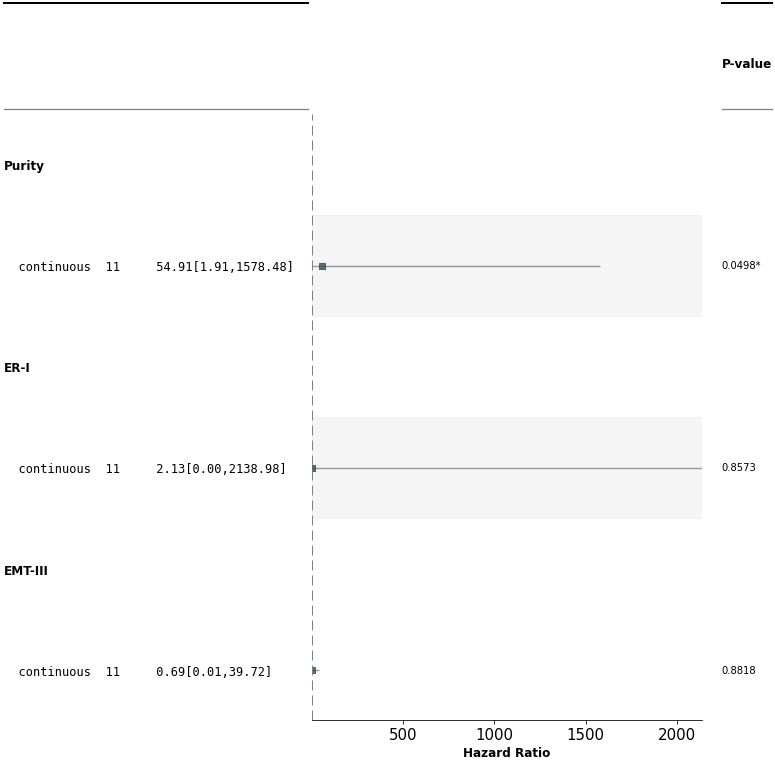

In [332]:
uni_test_result['N'] = uni_test_result['N'].astype(str)
# uni_test_result['group'] = uni_test_result['group'].replace(NAME_Map)
ax = fp.forestplot(uni_test_result.sort_values('p'),  # the dataframe with results data
              estimate="exp(coef)",  # col containing estimated effect size 
              ll="exp(coef) lower 90%", hl="exp(coef) upper 90%",  # columns containing conf. int. lower and higher limits
              varlabel="label",  # column containing variable label
              groupvar="group",  # Add variable groupings 
              pval="p",  # Column of p-value to be reported on right
              color_alt_rows=True,  # Gray alternate rows
              decimal_precision=4,
              annote=['N','est_and_ci'],
              annoteheaders=["N(pt)",'Est. (90% Conf. Int.)'],  # ^corresponding headers,
              xlabel="Hazard Ratio",
              table=True,  # Format as a table
              xline=1,
              figsize=(7,12),
              # Additional kwargs for customizations
              **{
                 "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                 "xlinecolor": "#808080",  # gray color for x-reference line
                 "xtick_size": 15,  # adjust x-ticker fontsize,
                 "thresholds":(0.001, 0.01, 0.05) # p value threshold
                }  
              )

# Zanudo 2024

In [26]:
gene_map = pd.read_csv(f'{EXTERNAL_DATA}/Zanudo_2024_Suppl_Data2/hg19_GRCh37p13-Gene stable ID - HGNC symbol - dictionary FINAL (2).csv',
                       index_col=0).set_index('hgnc_symbol_gene_id')['hgnc_symbol'].to_dict()

In [27]:
counts = (pd.read_csv(f'{EXTERNAL_DATA}/Zanudo_2024_Suppl_Data2/Gene expression counts - all genes.csv',
                     index_col=0).
          set_index('Sample_ID').
          rename(columns=gene_map).
          T.groupby(level=0).mean().T
         )

## Store CPM

In [25]:
cpm = pd.DataFrame(
    sc.pp.normalize_total(anndata.AnnData(X=counts),target_sum=1e6,inplace=False)['X'],
    index=counts.index,
    columns =counts.columns)
cpm.T.to_csv(f'{EXTERNAL_DATA}/Zanudo_2024_Suppl_Data2/CPM.tsv',sep='\t')

## TP53 analysis

In [29]:
mut = pd.read_csv(f'{EXTERNAL_DATA}/Zanudo_2024_Suppl_Data2/Final_maf_OKBannotated 2.tsv',
                  sep='\t')
obs = mut[['Sample_ID','purity']].drop_duplicates().set_index(['Sample_ID'])
obs['TP53'] = (pd.crosstab(mut['Sample_ID'],mut['Hugo_Symbol'])['TP53'] > 0).map({True:'Mut',False:'WT'})

In [28]:
ol_indices = counts.index.intersection(obs.index)
zanudo = anndata.AnnData(X=counts.loc[ol_indices ,:].astype(int),obs=obs.loc[ol_indices ,:])

In [29]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(zanudo, group='TP53', min_count=10, min_total_count=15)
# Filter by these genes
zanudo_filtered = zanudo[:, genes].copy()

# Build DESeq2 object
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=zanudo_filtered,
    design_factors=['TP53'],
    # continuous_factors=['purity'],
    refit_cooks=True,
    inference=inference,
)
# Compute LFCs
dds.deseq2()

# Running Wald test
stat_res = DeseqStats(
    dds,
    contrast=['TP53', 'Mut', 'WT'],
    inference=inference,
)
stat_res.summary()
results =  stat_res.results_df

Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 4.21 seconds.

Fitting dispersion trend curve...
... done in 2.02 seconds.

Fitting MAP dispersions...
... done in 4.93 seconds.

Fitting LFCs...
... done in 3.91 seconds.

Refitting 4911 outliers.

Fitting dispersions...
... done in 0.86 seconds.

Fitting MAP dispersions...
... done in 0.94 seconds.

Fitting LFCs...
... done in 0.91 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: TP53 Mut vs WT
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      11555.082776       -5.455586  1.851100 -2.947214  0.003207  0.126890
A1BG-AS1    202.607898       -0.310366  0.774699 -0.400627  0.688695  0.960241
A1CF       1431.208218       -9.378097  2.563258 -3.658662  0.000254  0.032379
A2M       31847.739301        0.149024  0.951731  0.156582  0.875574  0.984501
A2M-AS1      79.580776       -0.937644  1.114500 -0.841314  0.400172  0.899461
...                ...             ...       ...       ...       ...       ...
ZYG11A      162.030320        0.807395  1.111804  0.726203  0.467714  0.918972
ZYG11B     1325.546794       -0.007302  0.288603 -0.025302  0.979814  0.997447
ZYX        4353.122519        0.638060  0.459062  1.389921  0.164553  0.727665
ZZEF1      3796.664036        0.140206  0.909575  0.154144  0.877496  0.984501
ZZZ3       1941.104236        0.092347  0.448949  0.205697  0.837028  0.979413

... done in 2.09 seconds.



2024-04-12 16:15:50,127 [WARNING] Duplicated values found in preranked stats: 0.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-12 16:15:50,128 [INFO] Parsing data files for GSEA.............................
2024-04-12 16:15:50,133 [INFO] 0000 gene_sets have been filtered out when max_size=50 and min_size=1
2024-04-12 16:15:50,134 [INFO] 0009 gene_sets used for further statistical testing.....
2024-04-12 16:15:50,135 [INFO] Start to run GSEA...Might take a while..................
2024-04-12 16:15:50,287 [INFO] Congratulations. GSEApy runs successfully................



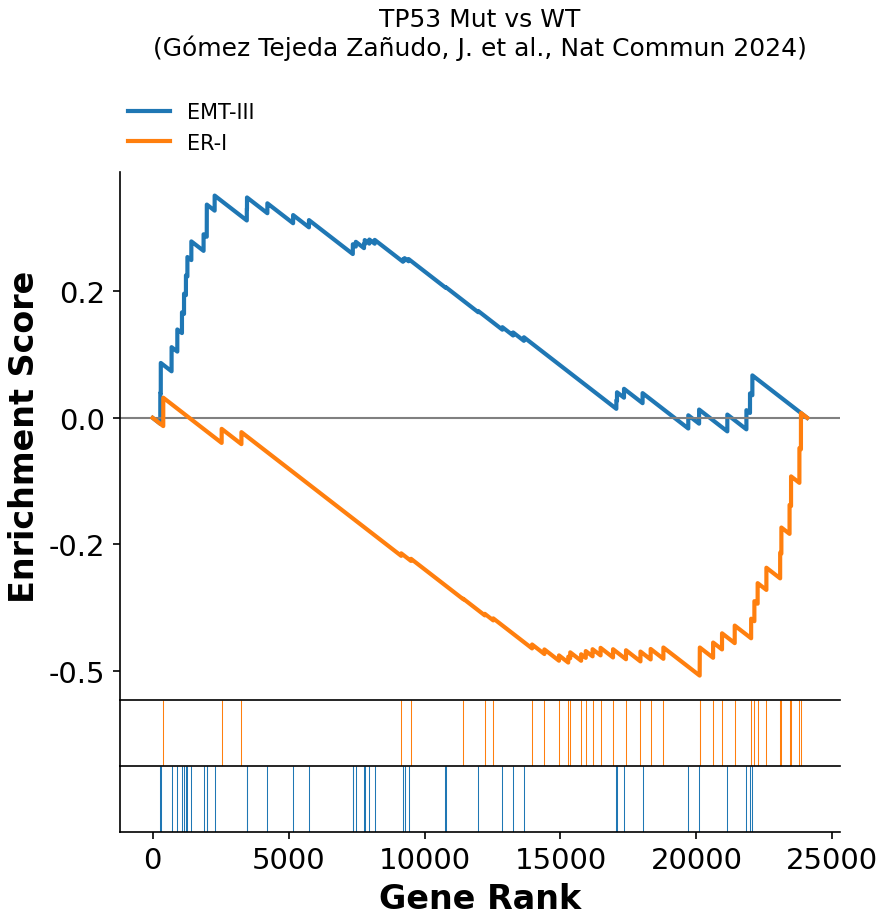

In [30]:
mp_sets = pd.read_csv(tumor_MP_gmt_path,sep='\t',header=None,index_col=0
                     ).T.rename(columns=MP_anno_map).drop([1],axis=0).to_dict('list')
pre_res = gp.prerank(rnk=results['stat'],
                     gene_sets=mp_sets,
                     min_size=1,
                     max_size=50,
                     permutation_num=50, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )
fig = pre_res.plot(terms=['EMT-III','ER-I'],show_ranking=False,figsize=(15,10))
fig.suptitle('TP53 Mut vs WT\n(Gómez Tejeda Zañudo, J. et al., Nat Commun 2024)',y=1.1)
fig.set_dpi(150)

## Cell fraction

In [34]:
fraction = pd.read_csv(f'{EXTERNAL_DATA}/Zanudo_2024_Suppl_Data2/Cellstate_Bisque_Fraction_Estimation.csv',
                          index_col=0)
fraction.index= fraction.index.str.replace('X','')
ol_indices = fraction.index.intersection(obs.index)
fraction = fraction.loc[ol_indices,:]
norm_score = fraction.copy()#[['Tumor.EMT-III','Tumor.ER-I']].copy()
tumor_frac = fraction.loc[:,fraction.columns.str.startswith('Tumor')].sum(axis=1)
norm_score = (norm_score.T/ tumor_frac).T
norm_score['TP53'] = obs.loc[norm_score.index,'TP53']

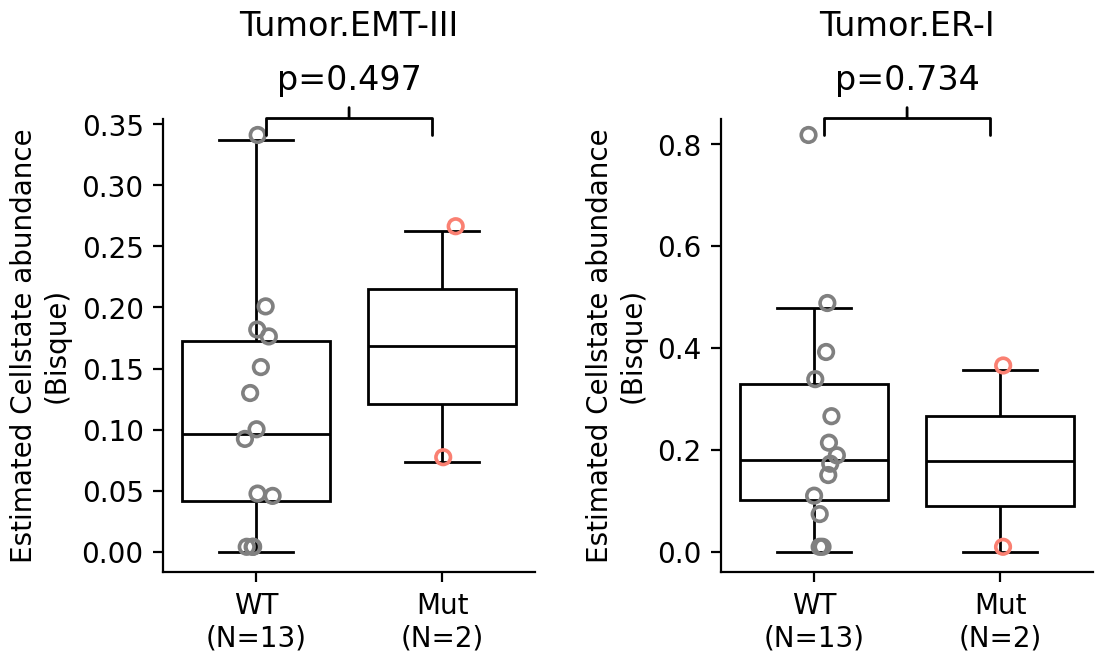

In [31]:
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
order=['WT','Mut']
palette={'WT':'gray','Mut':'salmon'}
ylabel='Estimated Cellstate abundance\n(Bisque)'
x='TP53'
fig,axs = plt.subplots(1,2,figsize=(6,3),dpi=200)

## Plot EMT-III
ax=axs[0]
# y='Tumor.Interferon/MHCII(I)'
y='Tumor.EMT-III'
sns.stripplot(data=norm_score,y=y,x=x,ax=ax,palette=palette,order=order,
              marker="$\circ$", ec="face",size=10)
sns.boxplot(data=norm_score,y=y,x=x,ax=ax,order=order,
            showfliers=False,linewidth=1,**PROPS)
ax.set(xlabel='',ylabel=ylabel)
ax.set_title(y,pad=30)
xticklabels=[]
for handle in ax.get_xticklabels():
    text = handle.get_text()
    xticklabels.append(f"{text}\n(N={(norm_score[x]==text).sum()})")
ax.set_xticklabels(xticklabels)
##### stats
z,pvalue = ranksums(norm_score.loc[norm_score[x]=='Mut',y].values,
                  norm_score.loc[norm_score[x].isin(['WT']),y].values)
ax.annotate(f"p={pvalue:.3f}", xy=(0.5, .99), xytext=(0.5, 1.05), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=.5', lw=1, color='k'))

## Plot ER-I
ax=axs[1]
y='Tumor.ER-I'
sns.stripplot(data=norm_score,y=y,x=x,ax=ax,palette=palette,order=order,
              marker="$\circ$", ec="face",size=10)
sns.boxplot(data=norm_score,y=y,x=x,ax=ax,order=order,
            showfliers=False,linewidth=1,**PROPS)
ax.set(xlabel='',ylabel=ylabel)
ax.set_title(y,pad=30)
xticklabels=[]
for handle in ax.get_xticklabels():
    text = handle.get_text()
    xticklabels.append(f"{text}\n(N={(norm_score[x]==text).sum()})")
ax.set_xticklabels(xticklabels)
##### stats
z,pvalue = ranksums(norm_score.loc[norm_score[x]=='Mut',y].values,
                  norm_score.loc[norm_score[x].isin(['WT']),y].values)
ax.annotate(f"p={pvalue:.3f}", xy=(0.5, .99), xytext=(0.5, 1.05), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=.5', lw=1, color='k'))

plt.subplots_adjust(wspace=.5)

## VISION scoring

In [43]:
zanudo = anndata.AnnData(X=counts.loc[ol_indices ,:].astype(int),obs=obs.loc[ol_indices ,:])
fraction = pd.read_csv(f'{EXTERNAL_DATA}/Zanudo_2024_Suppl_Data2/Celltype_Bisque_Fraction_Estimation.csv',
                          index_col=0)
fraction.index= fraction.index.str.replace('X','')
ol_indices = fraction.index.intersection(obs.index)
fraction = fraction.loc[ol_indices,:]

In [44]:
n_umi = zanudo.X.sum(axis=1)
scaled_counts = (zanudo.X.T / n_umi) * np.median(n_umi)
zanudo.X = scaled_counts.T
mp_result = sp.ext.VISION(data=zanudo,gmt_files=[tumor_MP_gmt_path],outdir='.')

Rscript /home/analysis/scPipe/scPipe/Rscripts/VISION.R --gmt_files ../../data/result/cleaned_files/MP_Programs.gmt --h5ad /tmp/tmp213leoz6/count.h5ad --output_file /tmp/tmp213leoz6/vision.tsv
$gmt_files
[1] "../../data/result/cleaned_files/MP_Programs.gmt"

$h5ad
[1] "/tmp/tmp213leoz6/count.h5ad"

$output_file
[1] "/tmp/tmp213leoz6/vision.tsv"



Loading data from ../../data/result/cleaned_files/MP_Programs.gmt ...

Using 36480/57797 genes detected in 0.10% of cells for signature analysis.
See the `sig_gene_threshold` input to change this behavior.

Evaluating signature scores on cells...

'as(<matrix>, "dgeMatrix")' is deprecated.
Use 'as(as(as(., "dMatrix"), "generalMatrix"), "unpackedMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").
Evaluating signature-gene importance...



In [45]:
norm_score = mp_result.rename(columns=MP_anno_map)
norm_score = (norm_score.T / fraction['Tumor']).T
norm_score['TP53']= zanudo.obs['TP53']

In [47]:
mp_result

,MP4,MP2,MP3,MP6,MP7,MP5,MP8,MP11,MP9
17_A1,1.800267,1.634159,1.544808,1.797038,1.606929,1.638491,1.509826,1.193231,1.279283
17_T1,1.786013,1.389312,1.752159,1.702340,1.357989,1.797715,1.445276,1.212049,1.067874
18_T1,1.459056,1.438670,2.066608,1.863951,1.139484,1.922636,1.378347,1.465909,0.798406
20_T1,1.851803,1.805655,2.372324,1.972473,1.149262,1.657897,1.688724,1.456202,0.985774
21_A1,2.099839,1.846781,2.278835,2.002351,1.668000,1.596086,1.355667,1.470971,1.359993
21_T1,1.802381,1.566249,1.598584,1.771900,1.185797,1.875366,1.490647,1.290923,0.970160
22_T1,1.738686,1.543311,2.107769,1.817039,1.574695,1.870826,1.295213,1.172899,1.300551
23_T1,1.872891,1.416674,1.825498,1.951493,1.096936,1.907826,1.437314,1.547195,0.775363
24_T1,1.938736,1.580167,1.921238,1.754666,1.383770,1.951330,1.082163,1.117477,1.578026
25_T1,2.091096,1.594942,2.050925,1.925797,1.141235,1.894186,1.169386,1.314365,0.858459


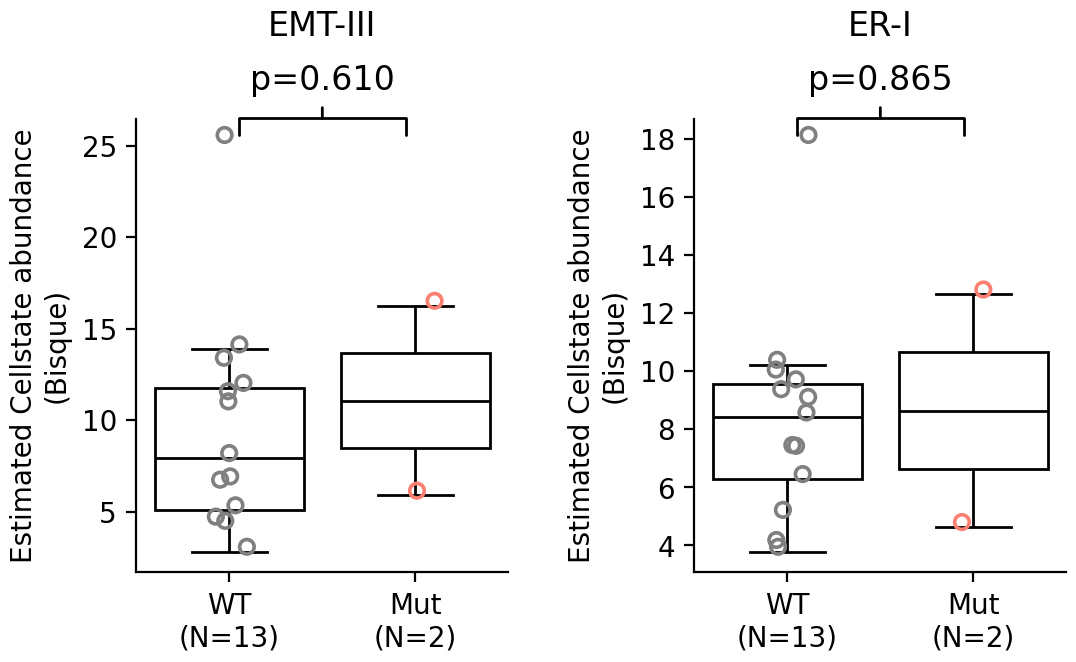

In [46]:
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
order=['WT','Mut']
palette={'WT':'gray','Mut':'salmon'}
ylabel='Estimated Cellstate abundance\n(Bisque)'
x='TP53'
fig,axs = plt.subplots(1,2,figsize=(6,3),dpi=200)

## Plot EMT-III
ax=axs[0]
# y='Tumor.Interferon/MHCII(I)'
y='EMT-III'
sns.stripplot(data=norm_score,y=y,x=x,ax=ax,palette=palette,order=order,
              marker="$\circ$", ec="face",size=10)
sns.boxplot(data=norm_score,y=y,x=x,ax=ax,order=order,
            showfliers=False,linewidth=1,**PROPS)
ax.set(xlabel='',ylabel=ylabel)
ax.set_title(y,pad=30)
xticklabels=[]
for handle in ax.get_xticklabels():
    text = handle.get_text()
    xticklabels.append(f"{text}\n(N={(norm_score[x]==text).sum()})")
ax.set_xticklabels(xticklabels)
##### stats
z,pvalue = ranksums(norm_score.loc[norm_score[x]=='Mut',y].values,
                  norm_score.loc[norm_score[x].isin(['WT']),y].values)
ax.annotate(f"p={pvalue:.3f}", xy=(0.5, .99), xytext=(0.5, 1.05), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=.5', lw=1, color='k'))

## Plot ER-I
ax=axs[1]
y='ER-I'
sns.stripplot(data=norm_score,y=y,x=x,ax=ax,palette=palette,order=order,
              marker="$\circ$", ec="face",size=10)
sns.boxplot(data=norm_score,y=y,x=x,ax=ax,order=order,
            showfliers=False,linewidth=1,**PROPS)
ax.set(xlabel='',ylabel=ylabel)
ax.set_title(y,pad=30)
xticklabels=[]
for handle in ax.get_xticklabels():
    text = handle.get_text()
    xticklabels.append(f"{text}\n(N={(norm_score[x]==text).sum()})")
ax.set_xticklabels(xticklabels)
##### stats
z,pvalue = ranksums(norm_score.loc[norm_score[x]=='Mut',y].values,
                  norm_score.loc[norm_score[x].isin(['WT']),y].values)
ax.annotate(f"p={pvalue:.3f}", xy=(0.5, .99), xytext=(0.5, 1.05), xycoords='axes fraction', 
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=.5', lw=1, color='k'))

plt.subplots_adjust(wspace=.5)